# Klayout Design Rule Checking (DRC)

Your device can be fabricated correctly when it meets the Design Rule Checks (DRC) from the foundry, you can write DRC rules from gdsfactory and customize the shortcut to run the checks in Klayout.

Here are some rules explained in [repo generic DRC technology](https://github.com/klayoutmatthias/si4all) and [video](https://peertube.f-si.org/videos/watch/addc77a0-8ac7-4742-b7fb-7d24360ceb97)

![rules1](https://i.imgur.com/gNP5Npn.png)

In [1]:
try:
    import google.colab

    is_running_on_colab = True
    !pip install gdsfactory gplugins > /dev/null

except ImportError:
    is_running_on_colab = False

In [2]:
import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.generic_tech import LAYER
from gdsfactory.typings import Float2, Layer

from gplugins.klayout.drc.write_drc import (
    check_area,
    check_density,
    check_enclosing,
    check_separation,
    check_space,
    check_width,
    write_drc_deck_macro,
)

In [3]:
help(write_drc_deck_macro)

Help on function write_drc_deck_macro in module gplugins.klayout.drc.write_drc:

write_drc_deck_macro(rules: 'list[str]', layers: 'dict[str, Layer] | None' = None, name: 'str' = 'generic', filepath: 'PathType | None' = None, shortcut: 'str' = 'Ctrl+Shift+D', mode: 'str' = 'tiled', threads: 'int' = 4, tile_size: 'int' = 500, tile_borders: 'int | None' = None) -> 'str'
    Write KLayout DRC macro.
    
    You can customize the shortcut to run the DRC macro from the Klayout GUI.
    
    Args:
        rules: list of rules.
        layers: layer definitions can be dict or dataclass.
        name: drc rule deck name.
        filepath: Optional macro path (defaults to .klayout/drc/name.lydrc).
        shortcut: to run macro from KLayout GUI.
        mode: tiled, default or deep (hierarchical).
        threads: number of threads.
        tile_size: in um for tile mode.
        tile_borders: sides for each. Defaults None to automatic.
    
    .. code::
    
        import gdsfactory as gf
  

In [4]:
rules = [
    check_width(layer="WG", value=0.2),
    check_space(layer="WG", value=0.2),
    check_width(layer="M1", value=1),
    check_width(layer="M2", value=2),
    check_space(layer="M2", value=2),
    check_separation(layer1="HEATER", layer2="M1", value=1.0),
    check_enclosing(layer1="M1", layer2="VIAC", value=0.2),
    check_area(layer="WG", min_area_um2=0.05),
    check_density(
        layer="WG", layer_floorplan="FLOORPLAN", min_density=0.5, max_density=0.6
    ),
]

drc_check_deck = write_drc_deck_macro(
    rules=rules,
    layers=LAYER,
    shortcut="Ctrl+Shift+D",
)

Wrote DRC deck to 'C:\\Users\\sajadi\\KLayout\\drc\\generic.lydrc' with shortcut 'Ctrl+Shift+D'


Lets create some DRC errors and check them on klayout.

2024-08-02 22:37:56.223 | INFO     | kfactory.kcell:show:7894 - klive v0.3.3: Opened file 'C:\Users\sajadi\AppData\Local\Temp\2269527101.gds'


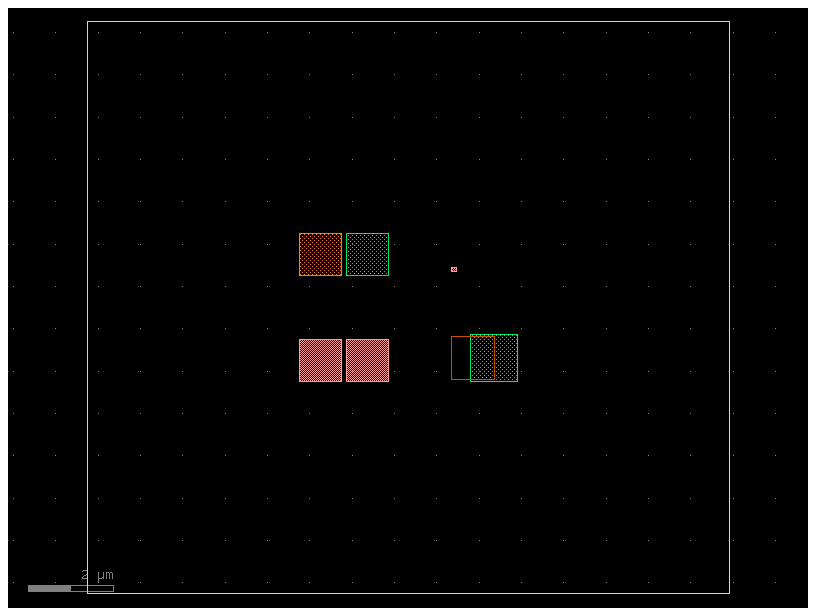

In [6]:
layer = LAYER.WG


@gf.cell
def width_min(size: Float2 = (0.1, 0.1)) -> Component:
    return gf.components.rectangle(size=size, layer=layer)


@gf.cell
def area_min() -> Component:
    size = (0.2, 0.2)
    return gf.components.rectangle(size=size, layer=layer)


@gf.cell
def gap_min(gap: float = 0.1) -> Component:
    c = gf.Component()
    r1 = c << gf.components.rectangle(size=(1, 1), layer=layer)
    r2 = c << gf.components.rectangle(size=(1, 1), layer=layer)
    r1.dxmax = 0
    r2.dxmin = gap
    return c


@gf.cell
def separation(
    gap: float = 0.1, layer1: Layer = LAYER.HEATER, layer2: Layer = LAYER.M1
) -> Component:
    c = gf.Component()
    r1 = c << gf.components.rectangle(size=(1, 1), layer=layer1)
    r2 = c << gf.components.rectangle(size=(1, 1), layer=layer2)
    r1.dxmax = 0
    r2.dxmin = gap
    return c


@gf.cell
def enclosing(
    enclosing: float = 0.1, layer1: Layer = LAYER.VIAC, layer2: Layer = LAYER.M1
) -> Component:
    """Layer1 must be enclosed by layer2 by value.

    checks if layer1 encloses (is bigger than) layer2 by value
    """
    w1 = 1
    w2 = w1 + enclosing
    c = gf.Component()
    c << gf.components.rectangle(size=(w1, w1), layer=layer1, centered=True)
    r2 = c << gf.components.rectangle(size=(w2, w2), layer=layer2, centered=True)
    r2.dmovex(0.5)
    return c


@gf.cell
def snapping_error(gap: float = 1e-3) -> Component:
    c = gf.Component()
    r1 = c << gf.components.rectangle(size=(1, 1), layer=layer)
    r2 = c << gf.components.rectangle(size=(1, 1), layer=layer)
    r1.dxmax = 0
    r2.dxmin = gap
    return c


@gf.cell
def errors() -> Component:
    components = [width_min(), gap_min(), separation(), enclosing()]
    c = gf.pack(components, spacing=1.5)
    c = gf.add_padding_container(c[0], layers=(LAYER.FLOORPLAN,), default=5)
    return c


c = errors()
c.show()  # show in klayout
c.plot()